<i><b>Public AI</b></i>
<br>
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 1. DNN Basis**
# Appendix 3. Regularization

### _Objective_
1. **Regularization**: 과적합과 과소적합에 대해 알아보고 다양한 정규화 방법들에 대해 알아봅니다.

In [1]:
# 필요한 library import 및 tensorflow 버전 확인
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import tensorflow as tf
from tensorflow import keras

np.random.seed(30)
tf.random.set_seed(30)

# \[ 1. Regularization \]


## 1. 과적합과 과소적합

과적합(Overfitting)이란, 모델이 데이터 셋에 과하게 적합화된 경우를 의미하고, <br>
과소적합(Underfitting)이란, 모델이 데이터 셋을 잘 맞추지 못하는 상태를 의미합니다. 

<img src="https://i.imgur.com/KvavIlG.png" width="800" height="600"/><br>

Train 데이터 셋에서의 오차가 큰 것을 편향(Bias)가 크다고 표현하고, <br>
Train 데이터셋에서의 오차와 Validation 데이터셋에서의 오차가 차이가 큰 것을 분산(Variance)이 크다고 표현합니다.

<img src="https://i.imgur.com/zw4Jeh9.png" width="800" height="600"/><br>

신경망이 데이터를 과대적합하는 문제가 발견되었을 때에는 보통 정규화를 적용합니다. <br>
정규화는 특성간의 높은 상관관계(collinearity)를 다루거나 데이터에서 잡음을 제거하여 과대적합을 방지할 수 있는 방법입니다.

## 2. 정규화의 효과

### 예제 데이터 ) 기술투자 비율과 예상 수익률 데이터 셋

기술 투자 비율과 예상 수익률에 대한 데이터셋입니다. <br>
아래와 같이 랜덤으로 50개의 데이터셋을 만들고, Test 데이터셋은 노이즈를 주지 않았습니다.<br>
데이터에 노이즈가 많고, 수가 적을 때 일반적으로 Overfitting이 발생하기 쉽습니다.

In [2]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

train_invests = np.random.uniform(0.05,0.9, 50)
train_growths = np.array([random_polynomial(x)+np.random.normal(0,0.02) 
           for x in train_invests]) # 예상 수익률

train_invests = train_invests.reshape(-1,1) 
train_growths = train_growths.reshape(-1,1) 

test_invests = np.linspace(0.05,0.9,30)
test_growths = np.array([random_polynomial(x)
                         for x in test_invests])

test_invests = test_invests.reshape(-1,1)
test_growths = test_growths.reshape(-1,1)

print("train 데이터셋 크기 : {}".format(len(train_invests)))
print("test 데이터셋 크기 : {}".format(len(test_invests)))

train 데이터셋 크기 : 50
test 데이터셋 크기 : 30


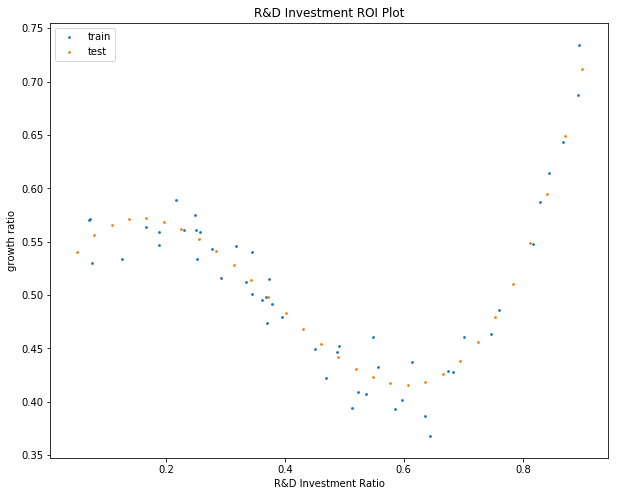

In [3]:
plt.figure(figsize=(10,8))
plt.scatter(train_invests, train_growths, s=3,label='train')
plt.scatter(test_invests, test_growths, s=3,label='test')
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.legend()
plt.show()

### 정규화 수식이 없는 인공 신경망

데이터가 부족하거나 노이즈가 많은 상황에서 인공 신경망은 쉽게 overfitting이 될 수 있습니다. 정규화 과정 없이 3-layer 신경망을 구성하고 예제 데이터를 학습시킨 후 결과를 확인해보겠습니다. 신경망의 구조는 아래와 같습니다.

* 신경망의 구조 : 
    1. 은닉층의 unit 갯수는 100개 입니다.
    2. 은닉층의 activation function은 `relu`이고 kernel_initializer는 `he_normal`입니다.
    3. 출력층의 unit 수는 1개 입니다.
    4. 출력층에서는 activation function을 사용하지 않고, kernel_initializer는 `glorot_normal`입니다.
    5. optimizer로는 SGD를 사용해주세요.
    6. learning rate는 0.01입니다.

In [4]:
num_hidden1 = 100
num_hidden2 = 100

model = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', kernel_initializer='he_normal', input_shape=(1,)),
    keras.layers.Dense(num_hidden2, activation='relu', kernel_initializer='he_normal',),
    keras.layers.Dense(1, kernel_initializer='glorot_normal')
])

model.compile(optimizer = tf.keras.optimizers.SGD(0.01), 
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(train_invests, train_growths, epochs=20000, verbose=0)

answer1 = model.predict(test_invests)

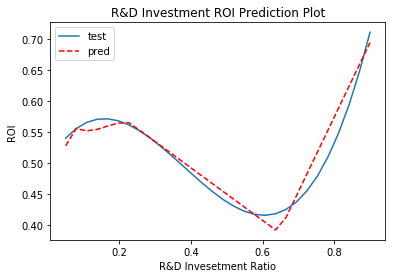

In [5]:
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_invests, answer1,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

## 3. L2 정규화

가장 대표적인 정규화 중 하나는  매개변수의 제곱항을 추가하는 L2 정규화입니다. 선형회귀에 L2 정규화를 취해준 모델을 보통 Ridge 선형회귀라고 부릅니다.

### (1) L2 정규화 수식
$$
\mbox{손실함수 : } J(w,b) = \frac{1}{m}\sum^{m}_{i=1}L(\hat y^{(i)},y^{(i)}) + \frac{\lambda}{2m}||w||^2\\
$$
추가된 항을 보통 L2 Norm, 혹은 Frobenius 노름이라고 부릅니다.<br>
위의 항을 추가하면, 손실함수의 Gradient 식에 변화가 생깁니다.<br>

$$
dW^{[L]} = \mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}W^{[L]}
$$
이를 Gradient Descent 수식에 적용하면 수식이 아래와 같이 변형됩니다.<br>
$$
W_{new}^{[L]} = W^{[L]} - \alpha*dW\\
W_{new}^{[L]} = W^{[L]} - \alpha*(\mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}W^{[L]})\\
W_{new}^{[L]} = (1-\frac{\alpha \lambda}{m})W^{[L]} - \alpha*(\mbox{(기존의 역전파로 온 값)}
$$

L2 정규화를 취해주게 되면 언제나 Weight값이 좀 더 줄어드는 효과가 생깁니다.<br>
그렇기 때문에 L2 정규화는 다른 말로 Weight decay라고도 불립니다.

### (2) L2 정규화를 사용한 인공 신경망

데이터가 부족하거나 노이즈가 많은 상황에서 인공 신경망은 쉽게 overfitting이 될 수 있습니다. L2 정규화 과정이 포함된 3-layer 신경망을 구성하고 예제 데이터를 학습시킨 후 결과를 확인해보겠습니다. Layer의 `kernel_regularizer`인자에 `keras.regularizers.l2`값을 주면 L2 정규화를 사용할 수 있습니다.

* 신경망의 구조 : 
    1. 은닉층의 unit 갯수는 100개 입니다.
    2. 은닉층의 activation function은 `relu`이고 kernel_initializer는 `he_normal`입니다.
    3. 각 은닉층에 `kernel_regularizer`인자를 활용해 L2 정규화를 사용해주세요.
    4. L2 parameter($\lambda$)의 값은 0.0005입니다.
    5. 출력층의 unit 수는 1개 입니다.
    6. 출력층에서는 activation function을 사용하지 않고, kernel_initializer는 `glorot_normal`입니다.
    7. optimizer로는 SGD를 사용해주세요.
    8. learning rate는 0.01입니다.

In [6]:
num_hidden1 = 100
num_hidden2 = 100

l2_model = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', kernel_initializer='he_normal', 
                       kernel_regularizer=keras.regularizers.l2(0.0005), input_shape=(1,)),
    keras.layers.Dense(num_hidden2, activation='relu', kernel_initializer='he_normal', 
                       kernel_regularizer=keras.regularizers.l2(0.0005)),
    keras.layers.Dense(1, kernel_initializer='glorot_normal')
])

l2_model.compile(optimizer = tf.keras.optimizers.SGD(0.01), 
                 loss='mean_squared_error', 
                 metrics=['accuracy'])

l2_model.fit(train_invests, train_growths, epochs=20000, verbose=0)

answer2 = l2_model.predict(test_invests)

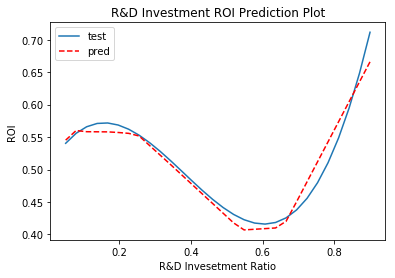

In [7]:
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_invests, answer2,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

## 4. L1 정규화

매개변수의 절대값을 추가하는 것이 L1 정규화입니다. L1 정규화는 수학적으로는 깔끔한 대수적 해가 존재하지 않을 수 있지만, 좀 더 모델이 Noise에 강건하게 만들어준다고 합니다. 우리가 선형회귀에 L1 정규화를 취해준 모델을 보통 Lasso 선형회귀라고 부릅니다.

### (1) L1 정규화 수식

L1 정규화는, 손실함수에 매개변수의 절대값을 추가한 것입니다.

$$
\mbox{손실함수 : } J(w,b) = \frac{1}{m}\sum^{m}_{i=1}L(\hat y^{(i)},y^{(i)}) + \frac{\lambda}{2m}||w||\\
$$
추가된 항을 보통 L1 Norm이라고 부릅니다.<br>
위의 항을 추가하면, 손실함수의 Gradient 식에 변화가 생깁니다.<br>

$$
dW^{[L]} = \mbox{(기존의 역전파로 온 값)} + \frac{\lambda}{m}sign(W)
$$

L2 정규화와 달리, Weight의 크기에 비례하지 않고, 단순히 Weight의 부호에 의해 결정됩니다.<br>
이 항의 추가로 인해, 0으로 되도 좋은 weight들을 0으로 만드는 효과를 발생합니다.<br>
그래서 L1 정규화는 주로, 특징 선택을 위한 하나의 수단으로도 이용되어 왔습니다.

### (2) L1 정규화를 사용한 인공 신경망

데이터가 부족하거나 노이즈가 많은 상황에서 인공 신경망은 쉽게 overfitting이 될 수 있습니다. L1 정규화 과정이 포함된 3-layer 신경망을 구성하고 예제 데이터를 학습시킨 후 결과를 확인해보겠습니다. Layer의 `kernel_regularizer`인자에 `keras.regularizers.l1`값을 주면 L1정규화를 사용할 수 있습니다.

* 신경망의 구조 : 
    1. 은닉층의 unit 갯수는 100개 입니다.
    2. 은닉층의 activation function은 `relu`이고 kernel_initializer는 `he_normal`입니다.
    3. 각 은닉층에 `kernel_regulrizer`인자를 활용해 L1 정규화를 사용해주세요.
    4. L1 parameter($\lambda$)의 값은 0.0005입니다.
    5. 출력층의 unit 수는 1개 입니다.
    6. 출력층에서는 activation function을 사용하지 않고, kernel_initializer는 `glorot_normal`입니다.
    7. optimizer로는 SGD를 사용해주세요.
    8. learning rate는 0.01입니다.

In [8]:
num_hidden1 = 100
num_hidden2 = 100

l1_model = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', kernel_initializer='he_normal', 
                       kernel_regularizer=keras.regularizers.l1(0.0005), input_shape=(1,)),
    keras.layers.Dense(num_hidden2, activation='relu', kernel_initializer='he_normal', 
                       kernel_regularizer=keras.regularizers.l1(0.0005)),
    keras.layers.Dense(1, kernel_initializer='glorot_normal')
])

l1_model.compile(optimizer = tf.keras.optimizers.SGD(0.01), 
                 loss='mean_squared_error', 
                 metrics=['accuracy'])

l1_model.fit(train_invests, train_growths, epochs=20000, verbose=0)

answer3 = l1_model.predict(test_invests)

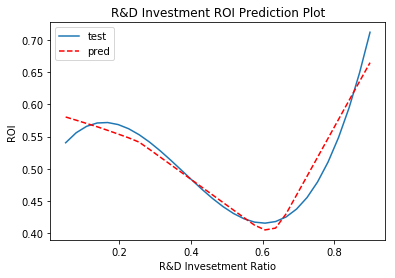

In [9]:
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_invests, answer3,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

## 5. Dropout

위에서 다룬 L1 & L2 정규화는 간단하게 구현할 수 있고 어느정도 overfitting을 억제할 수 있습니다. <br>
그러나 신경망 모델이 복잡해 지면 이것만으로는 대응하기 어려워집니다. 이럴 때 `Dropout`이라는 기법을 이용합니다. <br>

Dropout 알고리즘은 매우 간단합니다. 아래 이미지와 같이 매 훈련스텝에서 각 유닛들을 무작위로 골라 p% 확률로 끄는 방식의 알고리즘입니다. <br>
그리고 테스트를 하는 단계에서는 드롭아웃을 적용하지 않습니다.

<img src="https://i.imgur.com/m9diJOx.png" width="800" height="600"/>

### (1) 드랍아웃의 기술적 특징
1. Dropout은 일종의 앙상블 기법으로 설명하기도 합니다. 앙상블이란, 복수 개의 모델을 같이 이용해 결과를 계산하는 기법을 통칭합니다. <br>
2. Dropout은 일부 뉴런들을 꺼줌으로써, 부분 신경망(SubNetwork)를 구성하는 효과를 가집니다. <br>
3. Dropout은 한 유닛이 특정 input에만 의존하지 못하도록 만듭니다. 모든 input 유닛 값에 주의를 기울이게 되므로, 입력 값의 작은 변화에 덜 민감해집니다.

### (2) Dropout을 사용한 인공신경망

데이터가 부족하거나 노이즈가 많은 상황에서 인공 신경망은 쉽게 overfitting이 될 수 있습니다. Dropout 정규화 과정이 포함된 3-layer 신경망을 구성하고 예제 데이터를 학습시킨 후 결과를 확인해보겠습니다. `keras.layers.Dropout(dropout_rate)`를 활용해 dropout 층을 만들 수 있습니다.

* 조건 : 
    1. 은닉층의 unit 갯수는 100개 입니다.
    2. 은닉층의 activation function은 `relu`이고 kernel_initializer는 `he_normal`입니다.
    3. 각 은닉층 다음에 `keras.layers.Dropout(dropout_rate)`를 활용해 Dropout 층을 만들어 주세요.
    4. Dropout rate의 값은 0.5입니다.
    5. 출력층의 unit 수는 1개 입니다.
    6. 출력층에서는 activation function을 사용하지 않고, kernel_initializer는 `glorot_normal`입니다.
    7. optimizer로는 Adam을 사용해주세요.
    8. learning rate는 0.0001입니다.

In [10]:
# num_hidden1 = 100
num_hidden2 = 100
num_hidden3 = 100

dropout_model = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', kernel_initializer='he_normal', input_shape=(1,)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(num_hidden2, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, kernel_initializer='glorot_normal')
])

dropout_model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), 
                 loss='mean_squared_error', 
                 metrics=['accuracy'])

dropout_model.fit(train_invests, train_growths, epochs=20000, verbose=0)

answer4 = dropout_model.predict(test_invests)

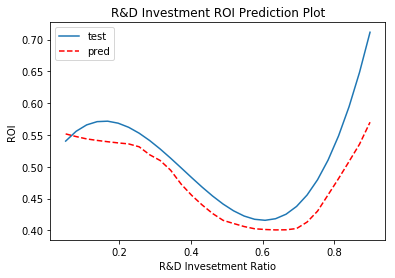

In [11]:
plt.plot(test_invests, test_growths,label='test')
plt.plot(test_invests, answer4,'r--',label='pred')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.legend()
plt.show()

#  

<hr>
<div>
    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, DoYeong Kim ( ka2k@publicai.co.kr )  last updated on 2019/10/07
</div>
<hr>